# Reddit Climate Change - Visualization of results

Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

# Corporate Design
plt.rc('font', size=14)
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["font.family"] = "Arial"
cmap = pltc.LinearSegmentedColormap.from_list("", ["#01353B", "#8AE3ED"])
color = "#006871"

In [22]:
df = pd.read_csv("data/comments_final_labels.csv", header=0, index_col=0)

## Total category distribution

<Axes: xlabel='climate_stance'>

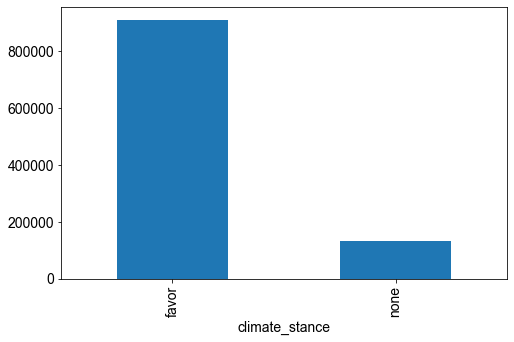

In [23]:
# Plot distribution

df.groupby(by="climate_stance").climate_stance.count().sort_values(ascending=False).plot.bar()

<Axes: xlabel='emotion_small'>

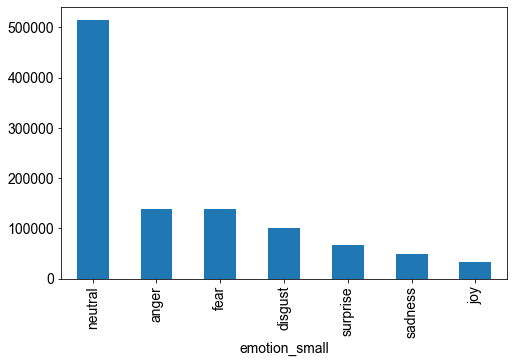

In [24]:
# Plot distribution
df.groupby(by="emotion_small").emotion_small.count().sort_values(ascending=False).plot.bar()

<Axes: xlabel='emotion_large'>

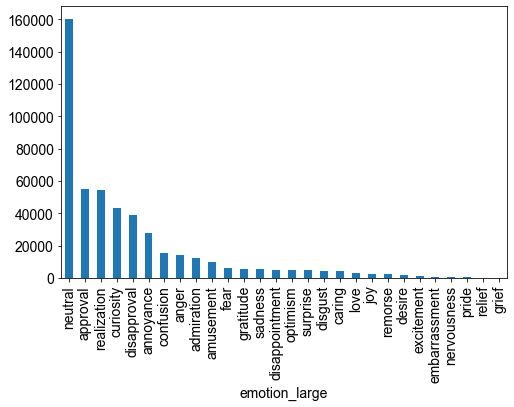

In [25]:
# Plot distribution
df.groupby(by="emotion_large").emotion_large.count().sort_values(ascending=False).plot.bar()

## Category distribution over time

In [40]:
df.groupby(by=["created_year", "emotion_large"]).count().id

created_year  emotion_large
2010          admiration        187
              amusement         130
              anger             146
              annoyance         438
              approval          850
                               ... 
2022          realization      5793
              relief             35
              remorse           221
              sadness           797
              surprise          500
Name: id, Length: 363, dtype: int64